In [1]:
pip install deap

     |████████████████████████████████| 153kB 4.9MB/s 


In [2]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz, ngf):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

class Classifier_B(nn.Module):
    def __init__(self):
        super(Classifier_B, self).__init__()

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 64, kernel_size=8, stride = 2, padding = 3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size=6, stride = 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels = 128, kernel_size=5, stride = 1)
        self.dropout2 = nn.Dropout(0.5)
        self.FC1 = nn.Linear(128, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        in_size = x.size(0)
        x = self.dropout1(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.dropout2(x)
        x = x.view(in_size, -1)
        x = self.FC1(x)
        x = self.softmax(x)
        
        return x
    
    def get_output(self, x):
        in_size = x.size(0)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(in_size, -1)
        x = self.FC1(x)
        x = self.softmax(x)

        return x

In [0]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
import glob
from torchvision import datasets, transforms
from PIL import Image
import torchvision.transforms.functional as TF
import random
from deap import creator, base, tools, algorithms
import os

# Hyper parameters
params = {
	'input_size': 28,  # image size 1x64x64
	'batch_size': 64,  # batch size
	'r': 10,   # population size
	'L': 50,  # number of iterations
	'nc': 1,  # number of channels
	'nz': 100,  # size of z latent vector
	'ngf': 64,  # size of feature maps in generator
	'ndf': 32,  # size of feature maps in discriminator
	'num_epochs': 1000,  # number of epochs
	'lr': 0.0001,  # learning rate
	'beta1': 0.5,   # beta1 for adam optimizer
	'ngpu': 1,  # number of GPU
	'lambda_gp': 10,  # loss weight for gradient penalty
	'n_critic': 5,
}

model_weight_path = './data/weights/netG_12500.pth'
classifier_weight_path = './classifiers/checkpoint'
netG = None
MSE_loss = nn.MSELoss()

# transform
transform = transforms.Compose([transforms.Normalize(mean=(0.5,), std=(0.5,))])

def imshow(img):
	img = (img + 1) / 2
	img = img.squeeze()
	np_img = img.numpy()
	plt.imshow(np_img, cmap='gray')
	plt.show()

def imshow_images(rec_rr, zs, netG):
	fig = plt.figure()
	for i in range(rec_rr):
		img = netG(zs[i]).detach()
		img = (img + 1) / 2
		img = img.squeeze()
		np_img = img.numpy()
		ax = fig.add_subplot(1,rec_rr,i+1)
		ax.imshow(np_img)
	plt.show()

def defensegan(x, observation_change=False, observation_step=100):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	x = x.view(28, 28).numpy().astype(np.float64)
	initial_population = torch.FloatTensor(params['r'], params['nz'], 1, 1).normal_(0, 1)
	initial_population = initial_population.view(params['r'], params['nz']).numpy()
	def evalFunc(individual):
		individual = torch.from_numpy(individual).view(1, params['nz'], 1, 1)
		fitness = np.linalg.norm(netG(individual).view(28, 28).detach().numpy() - x, ord=2) ** 2,
		return fitness
	def initIndividual(icls, content):
		return icls(content)
	def initPopulation(pcls, ind_init):
		return pcls(ind_init(c) for c in initial_population)
	creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
	creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)  # minimizing the fitness value
	toolbox = base.Toolbox()
	IND_SIZE = params['nz']
	POPULATION = params['r']
	CXPB, MUTPB = 0.4, 0.2
	GENERATIONS = params['L']
	toolbox.register("attr_float", random.random)
	toolbox.register("individual", initIndividual, creator.Individual)
	toolbox.register("population", initPopulation, list, toolbox.individual)
	toolbox.register("evaluate", evalFunc)
	toolbox.register("mate", tools.cxUniform, indpb=0.1)
	toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
	toolbox.register("select", tools.selTournament, tournsize=3)

	random.seed(777)

	# pop = toolbox.population(n=POPULATION)
	pop = toolbox.population()

	print("Start of evolution")

	# Evaluate the entire population
	# print(fitnesses) -> [(84,), (105,), (96,), (104,), (94,),  ... ] 이런식으로 저장됨.
	fitnesses = list(map(toolbox.evaluate, pop))
	for ind, fit in zip(pop, fitnesses):
		ind.fitness.values = fit

	# Extracting all the fitnesses of
	fits = [ind.fitness.values[0] for ind in pop]

	# Variable keeping track of the number of generations
	g = 0

	# Begin the evolution
	while min(fits) > 10 and g < GENERATIONS:
		# A new generation
		g = g + 1

		# Select the next generation individuals
		# len(pop) -> 50, len(pop[0]) -> 5
		offspring = toolbox.select(pop, len(pop))

		# Clone the selected individuals
		offspring = list(map(toolbox.clone, offspring))

		# Apply crossover and mutation on the offspring
		'''
        they modify those individuals within the toolbox container 
        and we do not need to reassign their results.
        '''
		# TODO: want p_new1 = p_m - beta(p_m - p_d), p_new2 = p_m + beta(p_m - p_d)
		# want to customize mutation method... there is no proper mutation operator in deap.tools...

		for child1, child2 in zip(offspring[::2], offspring[1::2]):
			if random.random() < CXPB:
				size = min(len(child1), len(child2))
				for i in range(5):
					cxpoint = random.randint(2, size - 1)
					mtpoint = cxpoint - 1
					# cxpoint -1 위치 : mutate
					beta = random.random()
					child1[mtpoint] = child1[mtpoint] - beta * (child1[mtpoint] - child2[mtpoint])
					child2[mtpoint] = child1[mtpoint] + beta * (child1[mtpoint] - child2[mtpoint])

				# crossover : one point crossover (temporary crossover algorithm)
				# child1[cxpoint:], child2[cxpoint:] = child2[cxpoint:], child1[cxpoint:]
				del child1.fitness.values
				del child2.fitness.values

		for child1, child2 in zip(offspring[::2], offspring[1::2]):
			if random.random() < CXPB:
				toolbox.mate(child1, child2)
				del child1.fitness.values
				del child2.fitness.values

		for mutant in offspring:
			if random.random() < MUTPB:
				toolbox.mutate(mutant)
				del mutant.fitness.values

		# Evaluate the individuals with an invalid fitness
		invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
		fitnesses = map(toolbox.evaluate, invalid_ind)
		for ind, fit in zip(invalid_ind, fitnesses):
			ind.fitness.values = fit

		# The population is entirely replaced by the offspring
		pop[:] = offspring

		# Gather all the fitnesses in one list and print the stats
		fits = [ind.fitness.values[0] for ind in pop]

		length = len(pop)
		mean = sum(fits) / length
		sum2 = sum(x * x for x in fits)
		std = abs(sum2 / length - mean ** 2) ** 0.5

		if g % 1 == 0:
			print("-- Generation %i --" % g)
			print("  Min %s" % min(fits))
			print("  Max %s" % max(fits))
			print("  Avg %s" % mean)
			print("  Std %s" % std)
			best_ind = tools.selBest(pop, 1)[0]
			z = torch.from_numpy(best_ind).view(1, 100, 1, 1)
			gen_image = netG(z)
			# imshow(gen_image.detach())

	print("-- End of (successful) evolution --")

	best_ind = tools.selBest(pop, 1)[0]
	z = torch.from_numpy(best_ind).view(1, 100, 1, 1)
	gen_image = netG(z)
	imshow(gen_image.detach())
	return gen_image

def main():
	# Generator(ngpu, nc, nz, ngf)
  global netG
  netG = Generator(params['ngpu'], params['nc'], params['nz'], params['ngf'])
  netG.load_state_dict(torch.load(gdrive_root + '/checkpoints/netG_12500.pth', map_location=torch.device('cpu')))

	# Classifier
  classifier_b = Classifier_B()
  classifier_b.load_state_dict(torch.load('/gdrive/My Drive/checkpoints/modelB_ckpt.pt')['model'])
  classifier_b.eval()

	# available epsilon values : 0.1, 0.2, 0.3, 0.05, 0.15, 0.25
  epsilon_set = [0.1, 0.2, 0.3, 0.05, 0.15, 0.25]
  acc_defense_gan = [0] * 6  # accuracy of defense GAN
  acc_classifier_b = [0] * 6  # accuracy of classifier b
  total = [0] * 6  # number of fgsm images for each epsilon
  correct_defense_gan = [0] * 6  # number of fgsm images correctly classified for each epsilon by defense gan
  correct_classifier_b = [0] * 6  # number of fgsm images correctly classified for each epsilon by classifier b

  for file_path in glob.glob("/gdrive/My Drive/classifier_b_fgsm_small_sample/*.jpg"):
    #for file_path in glob.glob("./data/fgsm_images_a/*.jpg"):  # fgsm images from classifier a (fgsm_images_a)
		# get epsilon and ground truth by parsing
    #print(file_path[48:])
    temp_file_path = file_path[48:]
    file_name = temp_file_path.split('_')
    epsilon = float(file_name[0])
    ground_truth = float(file_name[1])
    fgsm_truth = float(file_name[3])
    print('This fgsm image is originally ' + str(int(ground_truth)) + ', misclassified as ' +
			  str(int(fgsm_truth)) + ' with epsilon ' + str(epsilon))
    fgsm_image = Image.open(file_path)
    fgsm_image = TF.to_tensor(fgsm_image)
    #fgsm_image = transform(fgsm_image)  # torch.Size([1, 28, 28])
    imshow(fgsm_image)
    #print(fgsm_image)
    #break
    # do defense gan
    result_image = defensegan(fgsm_image)  # return type tensor [1, 1, 28, 28]. image G(z) that has minimum fitness
    # to classify image
    outputs_defense_gan = classifier_b(result_image)
    outputs_classifier_b = classifier_b(fgsm_image.view(1, 1, params['input_size'], params['input_size']))
    prediction_defense_gan = torch.max(outputs_defense_gan.data, 1)[1]
    prediction_classifier_b = torch.max(outputs_classifier_b.data, 1)[1]
    #print('output from defense gan is ' + str(outputs_defense_gan))
    #print('output from classifier is ' + str(outputs_classifier_b))
    print('defense gan classified fgsm image (' + str(ground_truth) + ' to ' + str(fgsm_truth) +
        ') as ' + str(prediction_defense_gan.item()))
    print('classifier b classified fgsm image (' + str(ground_truth) + ' to ' + str(fgsm_truth) +
        ') as ' + str(prediction_classifier_b.item()))
    epsilon_index = epsilon_set.index(epsilon)  # returns the index of epsilon from epsilon_set
    total[epsilon_index] += 1
    if prediction_defense_gan.item() == ground_truth:
      print('prediction from defense gan correct!')
      correct_defense_gan[epsilon_index] += 1
    if prediction_classifier_b.item() == ground_truth:
      print('prediction from classifier correct! - this should not happen...')
      correct_classifier_b[epsilon_index] += 1
    break
    print('total # images for each epsilon : ' + str(total))
    print('correct defense gan : ' + str(correct_defense_gan))
    print('correct classifier b : ' + str(correct_classifier_b))

This fgsm image is originally 0, misclassified as 3 with epsilon 0.2


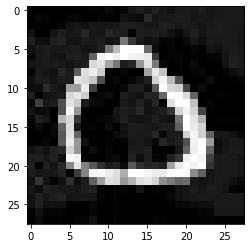

Start of evolution


/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


-- Generation 1 --
  Min 30.310498830193712
  Max 69.4214921879759
  Avg 43.562921995681116
  Std 14.055143491309053
-- Generation 2 --
  Min 30.310498830193712
  Max 70.06876425374793
  Avg 35.84225372007749
  Std 11.516277466075323
-- Generation 3 --
  Min 30.127709968863
  Max 32.33937331162695
  Avg 30.95482223702275
  Std 0.8340879660373212
-- Generation 4 --
  Min 29.674454662439345
  Max 32.14544906497983
  Avg 30.335626294598136
  Std 0.6358118909963257
-- Generation 5 --
  Min 29.10541364199549
  Max 30.312642966555654
  Avg 29.960820216172202
  Std 0.35610912025976793
-- Generation 6 --
  Min 28.983492860811936
  Max 30.209535347744765
  Avg 29.736534266865682
  Std 0.4231139437429797
-- Generation 7 --
  Min 28.51655477962248
  Max 30.236674991601934
  Avg 29.4396402711075
  Std 0.5626243769237277
-- Generation 8 --
  Min 28.539957229445623
  Max 29.82616729600891
  Avg 29.133454597250477
  Std 0.4810854991893426
-- Generation 9 --
  Min 28.539957229445623
  Max 29.580895439

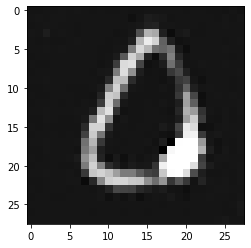

defense gan classified fgsm image (0.0 to 3.0) as 0
classifier b classified fgsm image (0.0 to 3.0) as 3
prediction from defense gan correct!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [41]:
main()